<a href="https://colab.research.google.com/github/garciafido/cima-goes/blob/master/cima_goes_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Install depencencies

In [0]:
!pip install -q netCDF4
!pip install -q  pyproj
!pip install -q aioftp
!pip install -q aiofiles
# Cartopy
!apt-get -q install libproj-dev proj-data proj-bin
!apt-get -q install libgeos-dev
!pip install -q  cython
!pip install -q  cartopy

# 2 - Install cima.goes library

In [2]:
!pip uninstall -y -q cima.goes
# !pip install --upgrade cima.goes
!pip install -q git+https://github.com/garciafido/cima-goes.git
!pip show cima.goes

Name: cima.goes
Version: 1.1b61
Summary: GOES-16 File Processing
Home-page: https://github.com/garciafido/cima-goes
Author: Fido Garcia
Author-email: garciafido@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: 


# 3 - Connect to Google Cloud Storage

To connect to Google Clud Storage (GCS) you need credentials. You can see how to obtain it at https://cloud.google.com/docs/authentication/getting-started?hl=es-419
You can write your credentiasl in code or retrieve them from network fyle system (NFS) or FTP
In this example we retrieve GCS credentials from an FTP server

In [0]:
import json
from cima.goes.storage import FTP, GCS


CREDENTIALS_FILEPATH = '/OTs/gcs_credentials.json'
FTP_HOST = '<Your Server URL>'
FTP_USER = '<Your User Name>'
FTP_PASSWORD = '<Your Password>'

def get_ftp_storage():
    return FTP(
        host=FTP_HOST,
        user=FTP_USER,
        password=FTP_PASSWORD)


def get_goes_storage_access():
    # Retrieve GCS credentials from FTP server
    ftp = get_ftp_storage()
    data = ftp.download_stream(CREDENTIALS_FILEPATH)
    credentials_as_dict = json.loads(data.decode('UTF-8'))

    # Create GOES storage access
    gcs = GCS(credentials_as_dict=credentials_as_dict)
    return gcs

print(get_goes_storage_access())

# 4 - Get blobs from storage
Bring blobs for certain bands of a GOES product

In [0]:
from cima.goes import Band, Product, ProductBand
from cima.goes.utils import timeit


@timeit
def getting_blobs():
    goes_storage = get_goes_storage_access()
    # Identify a product band
    band_IR = ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW)
    # Get all blobs of one hour
    blobs_IR = goes_storage.one_hour_blobs(2019, 60, 16, band_IR)
    print(f'Bands of {band_IR.band.name}')
    for blob in blobs_IR.blobs:
        print(blob.name)
    print('-' * 101)

    # Identify another product band
    band_VIS = ProductBand(Product.RadF, Band.RED)
    # Get all blobs grouped by starting time
    grouped_blobs = goes_storage.grouped_one_hour_blobs(2019, 76, 12, [band_VIS, band_IR])
    print(f'Grouped bands')
    for group in grouped_blobs:
        print(f'{group.start[7:9]}:{group.start[9:11]}')
        for band_blobs in group.blobs:
            print(f'    {band_blobs.band.name}', band_blobs.blobs[0].name)
    print('-' * 101)


getting_blobs()

# 5 -  Get a netCDF4 Dataset from a blob

In [0]:
@timeit
def get_netcdf_dataset(product_band):
    goes_storage = get_goes_storage_access()
    band_blobs = goes_storage.one_hour_blobs(2019, 60, 16, product_band)
    blob = band_blobs.blobs[0]
    dataset = goes_storage.get_dataset(blob)
    return dataset

    
print(get_netcdf_dataset(ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW)))


# 6 - Define some utility functions to show sample images

In [0]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cima.goes.tiles import get_tile_extent


def add_cultural(ax, color='none'):
    states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor=color)

    countries = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor=color)

    linewidth = 0.50
    ax.coastlines(resolution='10m', color='white', linewidth=linewidth)
    ax.add_feature(countries, edgecolor='white', linewidth=linewidth)
    ax.add_feature(states_provinces, edgecolor='white', linewidth=linewidth)


def add_grid(ax):
    linewidth = 1.25
    ax.gridlines(linewidth=linewidth,
                      linestyle='dotted',
                      color='r',
                      crs=ccrs.PlateCarree(),
                      draw_labels=True)

    
def show_tile(tile, 
              image=None, 
              lats=None, lons=None, 
              cmap=None, vmin=None, vmax=None, overlap=0):
    fig = plt.figure(figsize=(10, 10))
    try:
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        extent = get_tile_extent(tile, trim_excess=overlap)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        add_cultural(ax)
        ax.grid(color='r', linestyle='-', linewidth=2)
        add_grid(ax)
        fig.add_axes(ax, projection=ccrs.PlateCarree())
        if image is not None:
            ax.pcolormesh(lons, lats, image, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.show()
    finally:
        fig.clear()
        plt.close()


def show_rgb_tile(tile, 
              image=None, 
              lats=None, lons=None, 
              cmap=None, vmin=None, vmax=None, overlap=0, rgb=False):
    fig = plt.figure(figsize=(10, 10))
    try:
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        extent = get_tile_extent(tile, trim_excess=overlap)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
#         add_cultural(ax)
#         ax.grid(color='r', linestyle='-', linewidth=2)
#         add_grid(ax)
        fig.add_axes(ax, projection=ccrs.PlateCarree())
        if image is not None:
            mesh_rgb = image[:, :-1, :]
            colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
            # ADDED THIS LINE
            colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)
            # What you put in for the image doesn't matter because of the color mapping
            ax.pcolormesh(lons, lats, image[:,:,0], color=colorTuple)            
        plt.show()
    finally:
        fig.clear()
        plt.close()
        

# 7 - Show one Tile from a Dataset

ABI-L1b-RadF
get_netcdf_dataset  6760.88 ms


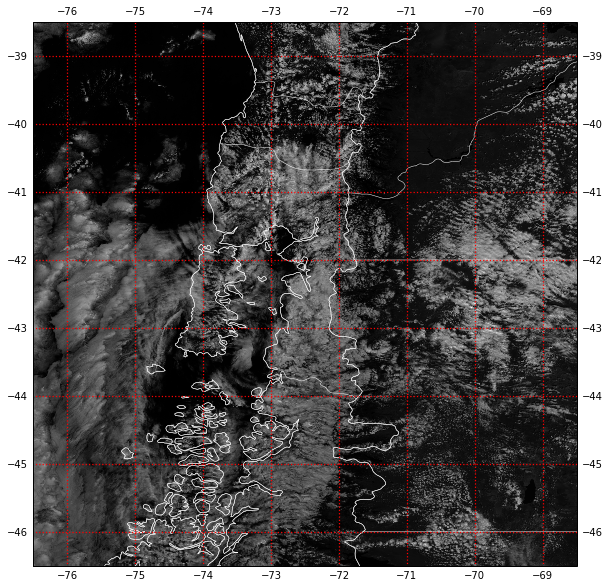

show_one_tile  10111.02 ms
ABI-L2-CMIPF
get_netcdf_dataset  6586.28 ms


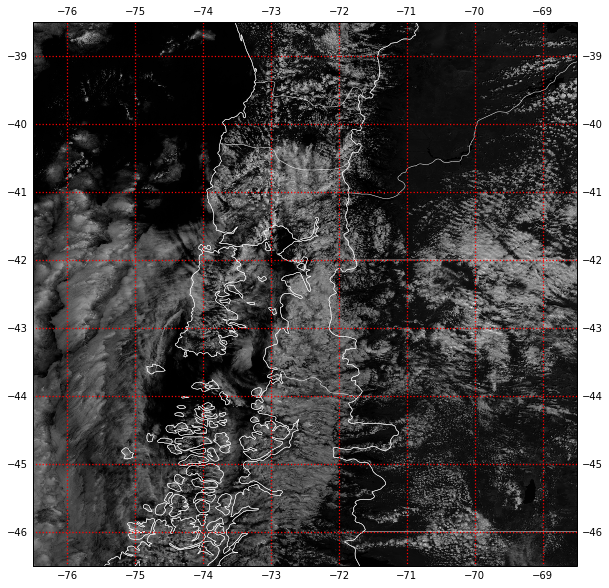

show_one_tile  9934.17 ms
RGB
get_netcdf_dataset  6609.20 ms
get_netcdf_dataset  2994.97 ms
get_netcdf_dataset  2618.08 ms


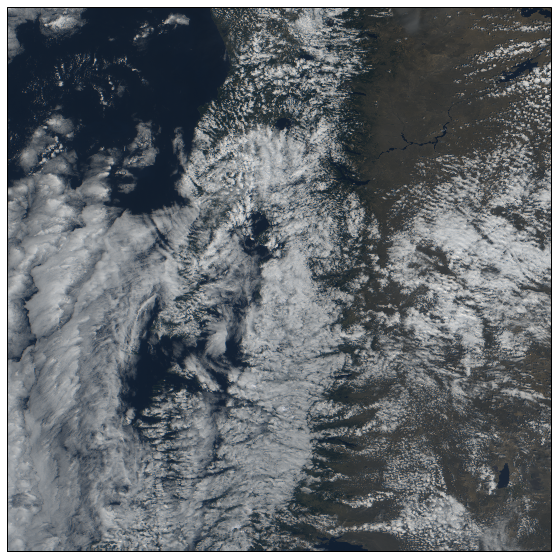

show_RGB  21929.31 ms


In [33]:
import numpy as np
from cima.goes.tiles import Tile
from cima.goes.data import CLOUD_TOPS_PALETTE, get_lats_lons, compose_RGB


def get_red_tile():    
    return Tile(
        lat_south=-46.5,
        lat_north=-38.5,
        lon_west=-76.5,
        lon_east=-68.5,
        x_min=10597,
        x_max=11928,
        y_min=18402,
        y_max=19512)

    
def get_color_tile():    
    return Tile(
        lat_south=-46.5, 
        lat_north=-38.5, 
        lon_west=-76.5, 
        lon_east=-68.5, 
        x_min=5298, 
        x_max=5964, 
        y_min=9201,
        y_max=9756)


@timeit
def show_RGB():
    print('RGB')
    R_ds = get_netcdf_dataset(ProductBand(Product.CMIPF, Band.RED)) 
    V_ds = get_netcdf_dataset(ProductBand(Product.CMIPF, Band.VEGGIE)) 
    B_ds = get_netcdf_dataset(ProductBand(Product.CMIPF, Band.BLUE))
    red_tile = get_red_tile()
    color_tile = get_color_tile()
    lats, lons = get_lats_lons(R_ds, red_tile)
    RGB, R, G, B = compose_RGB(R_ds, V_ds, B_ds, red_tile, color_tile, color_tile)
    show_rgb_tile(
        red_tile, 
        RGB,
        lats=lats, 
        lons=lons
        )

    
@timeit
def show_one_tile(product):
    print(product.value)
    albedo = lambda data: (data * np.pi * 0.3) / 663.274497
    transform = lambda data:  np.power(albedo(data), 1.5)
    if product == Product.RadF:
        variable = 'Rad'
    else:
        variable = 'CMI'
    dataset = get_netcdf_dataset(ProductBand(product, Band.RED)) 
    tile = get_red_tile()
    lats, lons = get_lats_lons(dataset, tile)
    data = dataset.variables[variable][
        tile.y_min : tile.y_max, 
        tile.x_min : tile.x_max
    ]
    data = transform(data)
    show_tile(
        tile, 
        image=data,
        lats=lats, 
        lons=lons, 
        cmap='gray'
        )

    
show_one_tile(Product.RadF)
show_one_tile(Product.CMIPF)
show_RGB()

# 8 - Generate Tiles for a region

In [0]:
from cima.goes.tiles import load_tiles, save_tiles, generate_region_tiles


TILES_FILEPATH = '/OTs/tiles_sample.json'
OVERLAP = 1.5

@timeit
def tiles_generation():
    # Generate and save tiles data
    goes_storage = get_goes_storage_access()
    bands = [
        ProductBand(Product.CMIPF, Band.VEGGIE),
        ProductBand(Product.CMIPF, Band.BLUE),
    ]
    all_tiles = {}
    for band in bands:
        band_tiles = generate_region_tiles(
            goes_storage,
            band,
            lat_south=-45,
            lat_north=-20,
            lon_west=-75,
            lon_east=-45,
            lat_step=5,
            lon_step=5,
            lon_overlap=OVERLAP,
            lat_overlap=OVERLAP
        )
        all_tiles = {**all_tiles, 
                     (band_tiles.product, band_tiles.band): band_tiles.tiles
                    }
        print('Generated: ', band_tiles.product, band_tiles.band)
    print('Generated: ', all_tiles)
    return all_tiles


def save_tiles_information(tiles):
    # Get FTP storage
    ftp = get_ftp_storage()
    save_tiles(ftp, TILES_FILEPATH, tiles)
    

def retrieve_tiles_information():
    # Retrieve the saved tiles data
    ftp = get_ftp_storage()
    tiles = load_tiles(ftp, TILES_FILEPATH)
    return tiles


# tiles = tiles_generation()
# save_tiles_information(tiles)
print(retrieve_tiles_information())


# 9 -  Using parallelism

In [0]:
from cima.goes.storage import mount_goes_storage
from cima.goes.tasks import Task, run_concurrent


def get_dataset(product_band, goes_storage):    
    band_blobs = goes_storage.one_hour_blobs(2019, 60, 16, product_band)
    blob = band_blobs.blobs[0]
    dataset = goes_storage.get_dataset(blob)
    return dataset


def show_band_tile(product_band, goes_storage_info, tile, title):
    goes_storage = mount_goes_storage(goes_storage_info)
    dataset = get_dataset(product_band, goes_storage)
    lats, lons = get_lats_lons(dataset, tile)
    data = dataset.variables['CMI'][
        tile.y_min : tile.y_max, 
        tile.x_min : tile.x_max
    ]
    print(title, data.shape)

@timeit
def sequential(goes_storage_info, blue, blue_tile, veggie, veggie_tile):
    show_band_tile(blue, goes_storage_info, blue_tile, 'Blues')                                                  
    show_band_tile(veggie, goes_storage_info, veggie_tile, 'Greens')                                                  
    
    
@timeit
def parallel(goes_storage_info, blue, blue_tile, veggie, veggie_tile):
    run_concurrent([
        Task(show_band_tile, blue, goes_storage_info, blue_tile, 'Blues'),                                                 
        Task(show_band_tile, veggie, goes_storage_info, veggie_tile, 'Greens')                                                  
    ], workers=2)
    
    
def main():
    # goes_storage is not serializable. 
    # Communication between processes needs a pickle-able object (goes_storage_info)
    goes_storage = get_goes_storage_access()
    goes_storage_info = goes_storage.get_storage_info()

    tiles = retrieve_tiles_information()
    blue = ProductBand(Product.CMIPF, Band.BLUE)
    blue_tile = tiles[(Product.CMIPF, Band.BLUE)]['0']
    veggie = ProductBand(Product.CMIPF, Band.VEGGIE)
    veggie_tile = tiles[(Product.CMIPF, Band.VEGGIE)]['0']
    sequential(goes_storage_info, blue, blue_tile, veggie, veggie_tile)
    parallel(goes_storage_info, blue, blue_tile, veggie, veggie_tile)
    sequential(goes_storage_info, blue, blue_tile, veggie, veggie_tile)
    parallel(goes_storage_info, blue, blue_tile, veggie, veggie_tile)
                                                      

main()                                                      